In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

from tqdm import tqdm
from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl

2025-12-10


In [2]:
workdir = '/mnt/disk7t/xwj/axolotl_rev'
os.system(f'mkdir -p {workdir}/result/table')
os.system(f'mkdir -p {workdir}/result/figure')
os.system(f'mkdir -p {workdir}/result/gtex_processed')

# level 1
output_path = f'{workdir}/result/dataset_gtex_nmd'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

tissues = pd.read_csv(f'{workdir}/gtex_processed/tissues.tsv', sep='\t', index_col=0)

In [3]:

# 遇到的问题 general.pred_outlier_auprc(df_pred, df_outlier)时NameError: name 'auc' is not defined
# 改成直接重定义
def sort_label_score_auprc(res_data, class_col, score_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    返回:
        auprc: AUPRC值
        pr_curve: 用于绘制的PR曲线点
    """
    # 按predict和score排序
    ascend = score_order[score_col]
    sorted_data = res_data.sort_values(by=[ class_col, score_col], ascending=[False, ascend])

    # 创建预测列
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    # 标记真实的异常点
    pr_curve['label'] = 0
    pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1
    
    # 计算precision和recall
    pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

    # 计算AUPRC
    auprc = auc(pr_curve['recall'], pr_curve['precision'])

    # 准备绘图用的曲线点
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
    return auprc, pr_curve.loc[idx]
    
def pred_outlier_auprc(df_pred, df_outlier):
    
    df_pred.index.name = 'Gene'
    df_pred.columns.name = 'Sample'
    pr_curve = df_pred.T.melt(ignore_index=False,value_name='pred').set_index(['Gene'],append=True).reorder_levels([1, 0])
    pr_curve = pr_curve.sort_values(by='pred',ascending=True)
    pr_curve['label'] = 0
    
    for i, row in df_outlier.iterrows(): 
    #     print(i,row['Gene'],row['Sample'])
        pr_curve.loc[(row['Gene'], row['Sample']), 'label' ] = 1
    pr_curve['rank'] = range(1,pr_curve.shape[0]+1,1)
    pr_curve['precision'] = (pr_curve['label'].cumsum()/pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum()/pr_curve['label'].sum()).round(4)

    # auprc value
    auprc = auc(pr_curve.loc[:,'recall'],pr_curve.loc[:,'precision'])
    
    # save a simple curve for plotting
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    # keep equally distributed points 
    idx = [ (pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg ]
    
    return auprc, pr_curve.loc[idx,]

## precision recall curve add segments for easy plotting
n_seg = 1000
recall_seg = np.linspace(0, 1,num=n_seg+1)

In [4]:
baselines = [ 'OUTRIDER', 'OUTSINGLE' ]

abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'padjust'] 
# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}
baselines = ['OUTSINGLE',]+ [ f'{m}_{score}' for m in [ 'OUTRIDER', 'ABEILLE'] for score in (outrider_scores if m=='OUTRIDER' else abl_scores) ]

mymethods = [ f'f{i}{md}' for i in list(range(20,24)) for md in ['L','I','O']] 
mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] 
             for m in ['L10', 'L20','L30', 'L40'] ]
# mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] for m in [ 'L30', ] ]
mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1', ] 
             for m in ['L20', 'I50', 'I100','I200', 'Ol','Op', 'Or',] ]
methods = [] + mymethods

# 20251205 只算baselines
methods = baselines
num = 49
phase = "_valid"
if True:
    phase = "_test"
    methods = ['f0.1L20', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTRIDER_padjust', 'OUTSINGLE']
print(num, phase, recall_seg, methods)

49 _test [0.    0.001 0.002 ... 0.998 0.999 1.   ] ['f0.1L20', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTRIDER_padjust', 'OUTSINGLE']


In [5]:
%%time
## 20251029 change to save pickle for one tissue & one method
# dict_outlier_setting = dict()
# dict_outlier_setting['all'] = {}
print(num, phase, recall_seg, methods)
for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    # --> level 2. (tissue, task) one tissue have many tasks
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
    samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
    # valid or test split
    outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
    print(prefix, samples.shape, outliers_used.shape)
    
    if 'Sample' in outliers_used.columns:
        df_outlier = outliers_used
    else:
        outlier_sample_col = 'SAMPLE_ID'
        outlier_gene_col = 'Gene'
        df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})
    for m in methods:
        # ==> level 3. (tissue, task, method)
        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        for j,row in task_config.iterrows():
            # ==> level 4. (tissue, task, method)
            if m.startswith('ABEILLE'):
                method, score = m.split('_',1)
                print(method, score)

                df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0, compression='gzip')
                df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                class_col = 'predict'
                dict_auprc[j], dict_curve[j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
            
            elif m.startswith('OUTRIDER'):
                method, score = m.split('_',1)
                print(method, score)
                df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0, compression='gzip')
                df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                class_col = 'aberrant'
                dict_auprc[j], dict_curve[j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                
            elif m == 'OUTSINGLE':
                print(m)
                df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                dict_auprc[j], dict_curve[j] = pred_outlier_auprc(df_pred, df_outlier)

                        
            else: # my method
                print(m)
                df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                dict_auprc[j], dict_curve[j] = pred_outlier_auprc(df_pred, df_outlier)
                    

        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method   
        outputdata = [ t, tn, i, dict_auprc, dict_curve ]

        with open(file, 'wb') as f: 
            pickle.dump( outputdata,  f )
    # debug, only run one tissue
    

49 _test [0.    0.001 0.002 ... 0.998 0.999 1.   ] ['f0.1L20', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTRIDER_padjust', 'OUTSINGLE']
t00_ADPSBQ_s648_g13675 (1, 648) (223, 8)
f0.1L20
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTRIDER padjust
OUTSINGLE
t01_ADPVSC_s531_g13728 (1, 531) (168, 8)
f0.1L20
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTRIDER padjust
OUTSINGLE
t02_ADRNLG_s254_g14019 (1, 254) (89, 8)
f0.1L20
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTRIDER padjust
OUTSINGLE
t03_ARTAORT_s424_g13793 (1, 424) (141, 8)
f0.1L20
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTRIDER padjust
OUTSINGLE
t04_ARTCRN_s233_g13797 (1, 233) (74, 8)
f0.1L20
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTRIDER padjust
OUTSINGLE
t05_ARTTBL_s653_g12768 (1, 653) (202, 8)
f0.1L20
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_scor

In [7]:
dict_auprc

{0: 0.0007652849999999999}

In [15]:
baselines

['OUTRIDER_padjust',
 'ABEILLE_anomaly_score',
 'ABEILLE_delta_count',
 'ABEILLE_divergence_score']

## Method development: LOF optimize 

L20 is the best LOF based model.

In [55]:
# use the minimum columns to merge table
cols4 = ['rank', 'label', 'precision', 'recall']

mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] 
             for m in ['L10', 'L20','L30', 'L40'] ]
draw_methods = baselines + mymethods
all_curves = []
auprc = pd.DataFrame(index=tissues.index, columns=draw_methods)

for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE

    dict_curve,dict_auprc = dict(),dict()
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_auprc[m], dict_curve[m] = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]

    required_sets = 1
    draw = \
    pd.concat([ 
        pd.concat([(dict_curve[m][j]) for j in range(required_sets)],
                axis=0, keys=range(required_sets)).reset_index(drop=True)
        for m in draw_methods], axis=0, keys=draw_methods)\
    .reset_index()
    
    draw['tissue'] = t
    all_curves.append(draw)
    auprc.loc[i,:] = [dict_auprc[m][0] for m in draw_methods]

all_curves = pd.concat(all_curves)
all_curves.shape

(1814813, 8)

In [56]:
# dict_curve.keys()

# [ (k,x[0].columns) for k,x in dict_curve.items() ]
# temp1 = dict_curve['OUTRIDER_padjust'][0].copy()
# temp2 = dict_curve['f0L10'][0].copy()
# print( temp1.shape, temp2.shape )
# pd.concat( [ temp2.drop(columns=['pred']), temp1[cols4], temp2[cols4]])

# pd.concat([(dict_curve[m][j][cols4]) for j in range(required_sets)],
#         axis=0, keys=range(required_sets))
# for m in draw_methods]

# for k,x in dict_curve.items():
#     print( k, x,)#.columns )


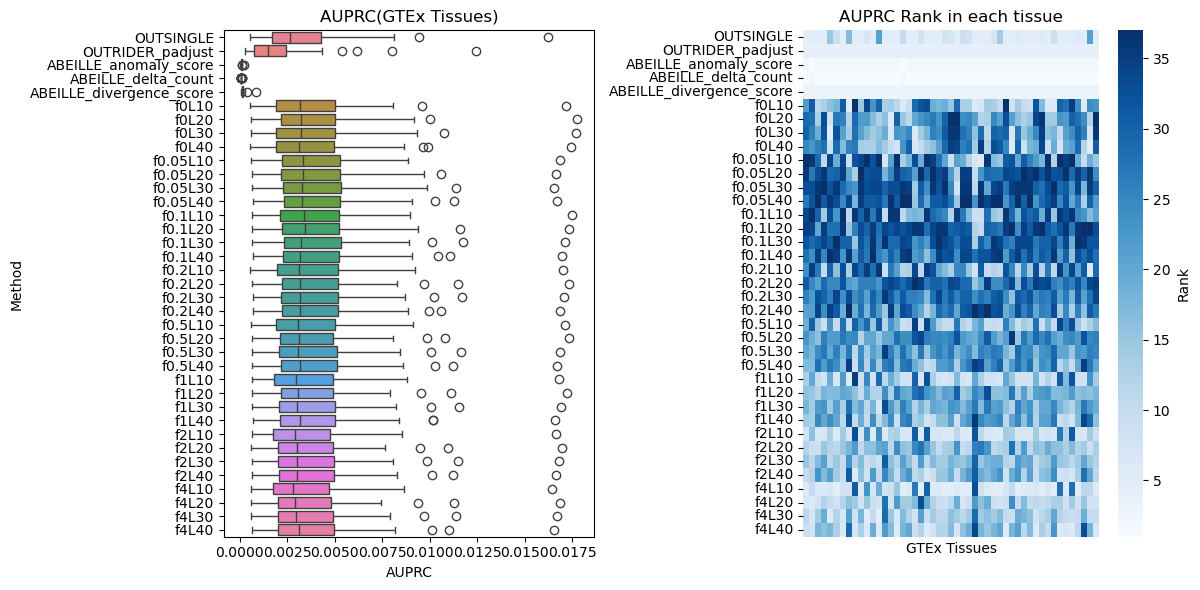

In [60]:
plt.style.use('default')

fig, axes = plt.subplots(1,2, figsize=(12, 6), sharey=False, )
auprc_long = auprc.astype(np.float32).stack().reset_index(name='AUPRC').rename(columns={'level_1':'Method', 'level_0':'Tissue'})
sns.boxplot( auprc_long,  x = 'AUPRC', y='Method', orient='h', hue='Method', ax=axes[0],)
# axes[0].set_xscale('log')
# ticks = [ 0.001, 0.005, 0.01, 0.02, 0.03, 0.05]
# axes[1].set_xticks(ticks)
# axes[1].set_xticklabels([str(t) for t in ticks])
axes[0].set_xlabel('AUPRC')
axes[0].set_title('AUPRC(GTEx Tissues)')

# （3） ascending 
auprc_rank = auprc.rank(axis=1, method='min')
sns.heatmap(
    auprc_rank.T,  # 原始值作为注释
    annot=False,  # 显示数值
    fmt='.3f',  # 数值格式
    cmap='Blues',  # 使用蓝色渐变
    cbar_kws={'label': 'Rank'},  # 色条标签
    linecolor=None, linewidths=0.05,
    xticklabels=False,
    yticklabels=True,
    ax=axes[1],
)

axes[1].set_title('AUPRC Rank in each tissue')
axes[1].set_xlabel('GTEx Tissues')
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/gtex_valid_auprc_box_localoutlierfactor.pdf', dpi=200)

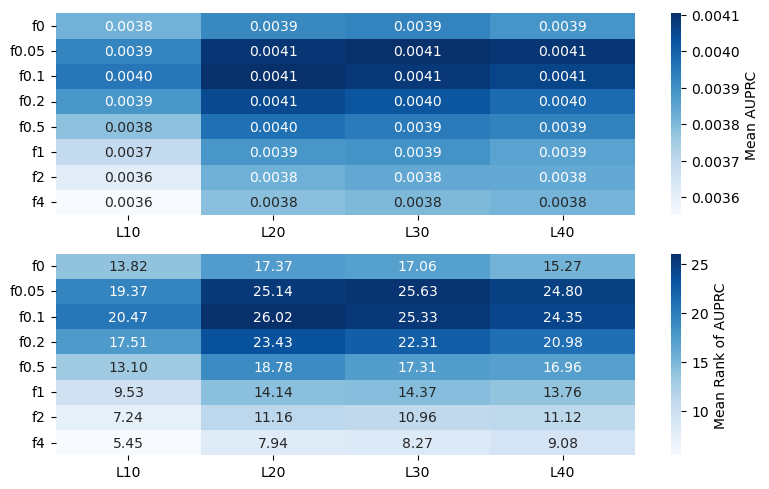

In [107]:
# fig, axes = plt.subplots(1,3, figsize=(15, 2),sharey=False, ) # 横排列
fig, axes = plt.subplots(2,1,figsize=(8, 5),sharey=False, )

draw = auprc[mymethods].copy()
# 原始列名
# columns = ['f0L10', 'f0L20', 'f0L40', 'f0.05L10', 'f0.05L20', 'f0.05L40',
#            'f0.1L10', 'f0.1L20', 'f0.1L40', 'f0.2L10', 'f0.2L20', 'f0.2L40',
#            'f0.5L10', 'f0.5L20', 'f0.5L40', 'f1L10', 'f1L20', 'f1L40', 'f2L10',
#            'f2L20', 'f2L40', 'f4L10', 'f4L20', 'f4L40']

# 分割列名
def split_col(col):
    # 找到'L'的位置
    l_pos = col.find('L')
    # 分割为两部分
    return (col[:l_pos], col[l_pos:])
import re
# ① 只切一次：按最先出现的 L|I|O 切开
def split_col(col: str):
    # 正则：第一个 [LIO] 及其左边为 part1，右边为 part2
    m = re.search(r'([LIO])', col)
    if not m:               # 找不到就原样返回
        return (col, '')
    pos = m.start()         # 第一个 L/I/O 的位置
    return (col[:pos], col[pos:])

# 创建多级索引
draw.columns = pd.MultiIndex.from_tuples([split_col(col) for col in draw.columns ])
# sns.heatmap( )
sns.heatmap(draw.mean().astype(np.float32).unstack(), annot=True, fmt='.4f', 
            cmap='Blues', cbar_kws={'label': 'Mean AUPRC'}, linewidths=0, linecolor='black',
            ax=axes[0],)

draw = auprc[mymethods].copy().rank(axis=1)
draw.columns = pd.MultiIndex.from_tuples([split_col(col) for col in draw.columns ])
sns.heatmap(draw.mean().astype(np.float32).unstack(), annot=True, fmt='.2f', 
            cmap='Blues', cbar_kws={'label': 'Mean Rank of AUPRC'}, linewidths=0, linecolor='black',
            ax=axes[1],)
axes[0].tick_params(axis='both', rotation=0)
axes[1].tick_params(axis='both', rotation=0)
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/gtex_valid_auprc_mean_heatmap_localoutlierfactor.pdf', dpi=200)

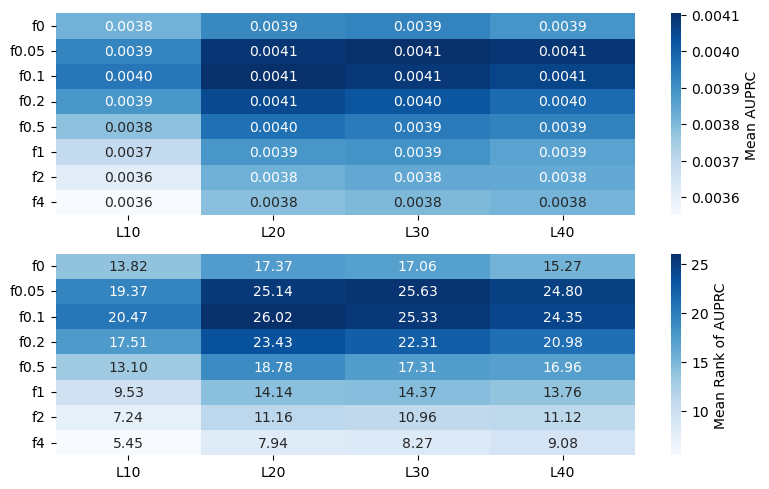

In [ ]:
# p-value
auprc = auprc.astype(np.float32)

from scipy.stats import wilcoxon
import itertools

columns = auprc.columns.tolist()
results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

for method1, method2 in itertools.combinations(columns, 2):
    x = auprc[method1].dropna()
    y = auprc[method2].dropna()
    
    # make they are same length
    min_len = min(len(x), len(y))
    x = x.iloc[:min_len]
    y = y.iloc[:min_len]
    
    # wilcoxon test
    alternative = 'two-sided'
    stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

    new_row = pd.DataFrame({
        'Method1': [method1],
        'Method2': [method2],
        'Statistic': [stat],
        'p-value': [p_value]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)

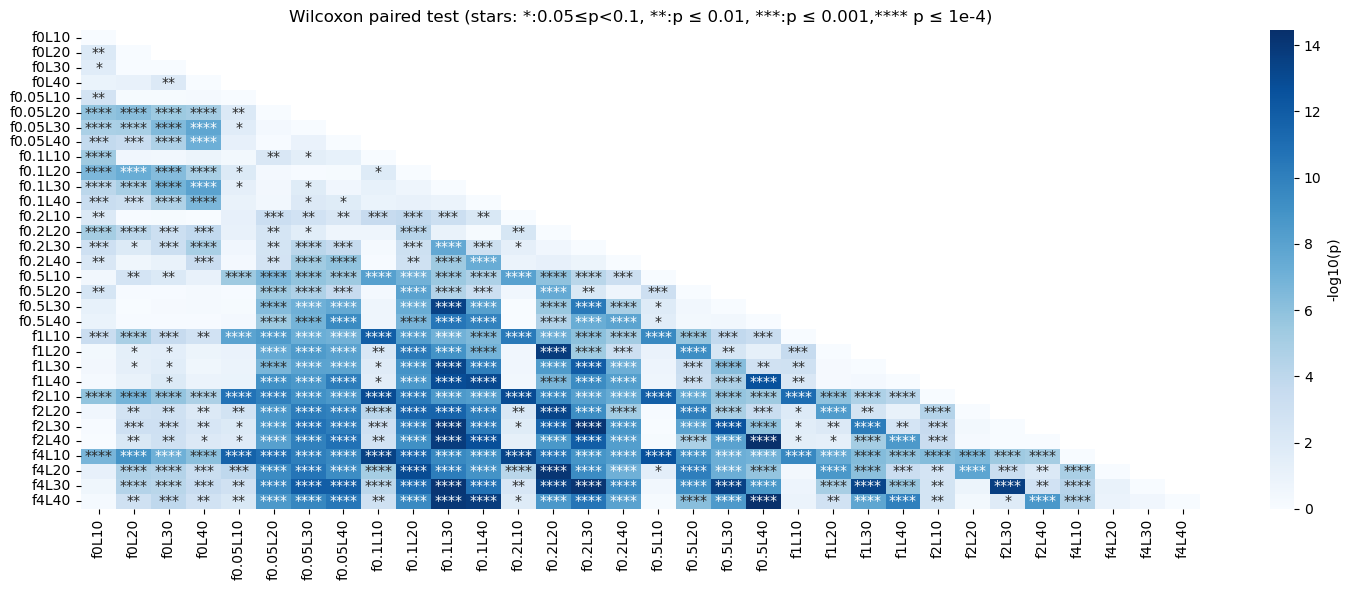

In [115]:
axo_results = results.query('(Method1 not in @baselines) and (Method2 not in @baselines)')
# ---- 1. 对称矩阵化 ----
pivot = axo_results.pivot(index='Method1', columns='Method2', values='p-value')
pivot = pivot.combine_first(pivot.T)        # 补全下三角
np.fill_diagonal(pivot.values, 1)           # 对角=1
pivot = pivot.loc[mymethods, mymethods]
# ---- 2. -log10 变换 ----
log_p = -np.log10(pivot)
log_p = log_p.replace([np.inf, -np.inf], np.nan)

# ---- 3. 三角掩码 ----
mask = np.triu(np.ones_like(log_p, dtype=bool), k=1)

def p2star(p):
    if pd.isna(p) or p > 0.05:
        return ''
    elif p <= 1e-4:
        return '****'
    elif p <= 1e-3:
        return '***'
    elif p <= 1e-2:
        return '**'
    else:
        return '*'

# 1. 星号对称矩阵（同索引）
star_mat = pivot.applymap(p2star)

# ---- 4. 画图 ----
plt.figure(figsize=(15, 6))
sns.heatmap(log_p,
            mask=mask,
            cmap='Blues',
            annot=star_mat,
            fmt='',
            cbar_kws={'label': '-log10(p)'})
plt.title('Wilcoxon paired test (stars: *:0.05≤p<0.1, **:p ≤ 0.01, ***:p ≤ 0.001,**** p ≤ 1e-4)')
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/gtex_valid_auprc_wilcox_p_star_localoutlierfactor.pdf', dpi=200)


## Method development: LOF is better than IF and OCSVM
L20 is the best LOF based model. To show LOF is advantage, try isolation forest based model(I50~I200) and OCSVM(rbf, linear, poly)

In [62]:
print(phase)
mymethods = [ f'{f}{m}' for m in ['L20', 'I50', 'I100','I200', 'Ol','Op', 'Or',] for f in ['f0', 'f0.05','f0.1', ] ]
draw_methods = baselines + mymethods
    
all_curves = []
auprc = pd.DataFrame(index=tissues.index, columns=draw_methods)

for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE

    dict_curve,dict_auprc = dict(),dict()
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_auprc[m], dict_curve[m] = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]

    required_sets = 1
    draw = \
    pd.concat([ 
        pd.concat([(dict_curve[m][j]) for j in range(required_sets)],
                axis=0, keys=range(required_sets)).reset_index(drop=True)
        for m in draw_methods], axis=0, keys=draw_methods)\
    .reset_index()
    
    draw['tissue'] = t
    all_curves.append(draw)
    auprc.loc[i,:] = [dict_auprc[m][0] for m in draw_methods]

all_curves = pd.concat(all_curves)
all_curves.shape

_valid


(1275274, 8)

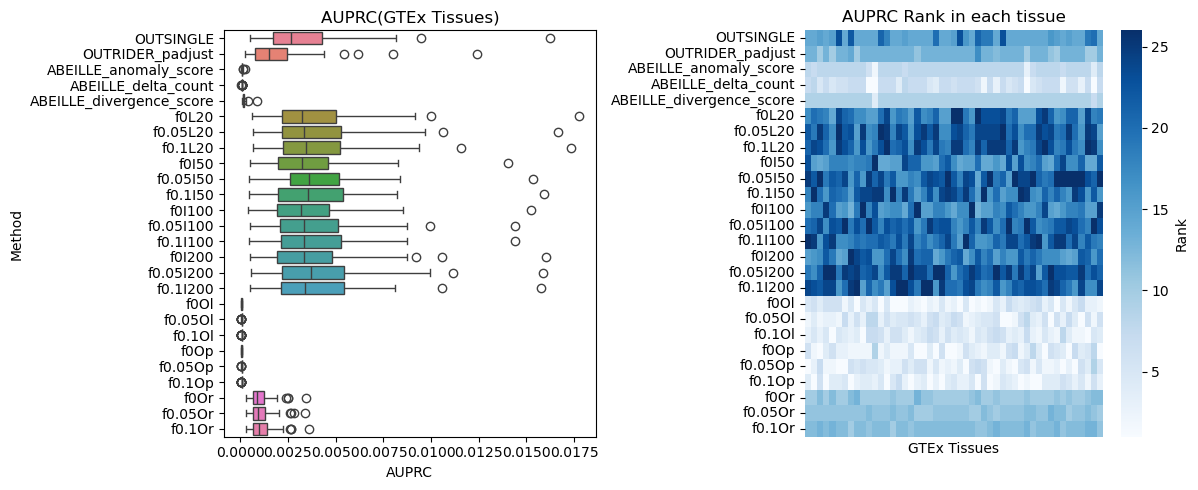

In [64]:
fig, axes = plt.subplots(1,2, figsize=(12, 5), sharey=False, )
auprc_long = auprc.astype(np.float32).stack().reset_index(name='AUPRC').rename(columns={'level_1':'Method', 'level_0':'Tissue'})
sns.boxplot( auprc_long,  x = 'AUPRC', y='Method', orient='h', hue='Method', ax=axes[0],)
# axes[0].set_xscale('log')
# ticks = [ 0.001, 0.005, 0.01, 0.02, 0.03, 0.05]
# axes[1].set_xticks(ticks)
# axes[1].set_xticklabels([str(t) for t in ticks])
axes[0].set_xlabel('AUPRC')
axes[0].set_title('AUPRC(GTEx Tissues)')

# （3） ascending 
auprc_rank = auprc.rank(axis=1, method='min')
sns.heatmap(
    auprc_rank.T,  # 原始值作为注释
    annot=False,  # 显示数值
    fmt='.3f',  # 数值格式
    cmap='Blues',  # 使用蓝色渐变
    cbar_kws={'label': 'Rank'},  # 色条标签
    linecolor=None, linewidths=0.05,
    xticklabels=False,
    yticklabels=True,
    ax=axes[1],
)

axes[1].set_title('AUPRC Rank in each tissue')
axes[1].set_xlabel('GTEx Tissues')
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/gtex_valid_auprc_box.pdf', dpi=200)

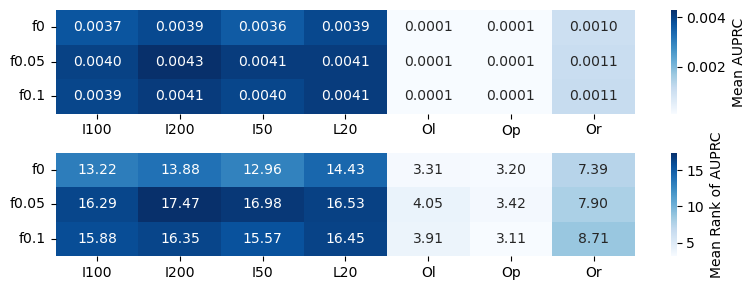

In [ ]:
# fig, axes = plt.subplots(1,3, figsize=(15, 2),sharey=False, ) # 横排列
fig, axes = plt.subplots(2,1,figsize=(8, 3),sharey=False, )

draw = auprc[mymethods].copy()
# 原始列名
# columns = ['f0L10', 'f0L20', 'f0L40', 'f0.05L10', 'f0.05L20', 'f0.05L40',
#            'f0.1L10', 'f0.1L20', 'f0.1L40', 'f0.2L10', 'f0.2L20', 'f0.2L40',
#            'f0.5L10', 'f0.5L20', 'f0.5L40', 'f1L10', 'f1L20', 'f1L40', 'f2L10',
#            'f2L20', 'f2L40', 'f4L10', 'f4L20', 'f4L40']

# 分割列名
def split_col(col):
    # 找到'L'的位置
    l_pos = col.find('L')
    # 分割为两部分
    return (col[:l_pos], col[l_pos:])
import re
# ① 只切一次：按最先出现的 L|I|O 切开
def split_col(col: str):
    # 正则：第一个 [LIO] 及其左边为 part1，右边为 part2
    m = re.search(r'([LIO])', col)
    if not m:               # 找不到就原样返回
        return (col, '')
    pos = m.start()         # 第一个 L/I/O 的位置
    return (col[:pos], col[pos:])

# 创建多级索引
draw.columns = pd.MultiIndex.from_tuples([split_col(col) for col in draw.columns ])
# sns.heatmap( )
sns.heatmap(draw.mean().astype(np.float32).unstack(), annot=True, fmt='.4f', 
            cmap='Blues', cbar_kws={'label': 'Mean AUPRC'}, linewidths=0, linecolor='black',
            ax=axes[0],)

draw = auprc[mymethods].copy().rank(axis=1)
draw.columns = pd.MultiIndex.from_tuples([split_col(col) for col in draw.columns ])
sns.heatmap(draw.mean().astype(np.float32).unstack(), annot=True, fmt='.2f', 
            cmap='Blues', cbar_kws={'label': 'Mean Rank of AUPRC'}, linewidths=0, linecolor='black',
            ax=axes[1],)
axes[0].tick_params(axis='both', rotation=0)
axes[1].tick_params(axis='both', rotation=0)
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/gtex_valid_auprc_mean_heatmap.pdf', dpi=200)


In [66]:
baselines

['OUTSINGLE',
 'OUTRIDER_padjust',
 'ABEILLE_anomaly_score',
 'ABEILLE_delta_count',
 'ABEILLE_divergence_score']

[('OUTRIDER_padjust', 'f0.1L20'), ('OUTSINGLE', 'f0.1L20'), ('f0.1L20', 'f0.05I200'), ('f0.1L20', 'f0.1Or')]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

f0.1L20 vs. f0.05I200: Wilcoxon test (paired samples), P_val:2.899e-01 Stat=5.050e+02
f0.1L20 vs. f0.1Or: Wilcoxon test (paired samples), P_val:3.553e-15 Stat=0.000e+00
OUTRIDER_padjust vs. f0.1L20: Wilcoxon test (paired samples), P_val:3.553e-15 Stat=0.000e+00
OUTSINGLE vs. f0.1L20: Wilcoxon test (paired samples), P_val:1.066e-14 Stat=2.000e+00


/tmp/ipykernel_16939/117535137.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(draw_methods_new_name)


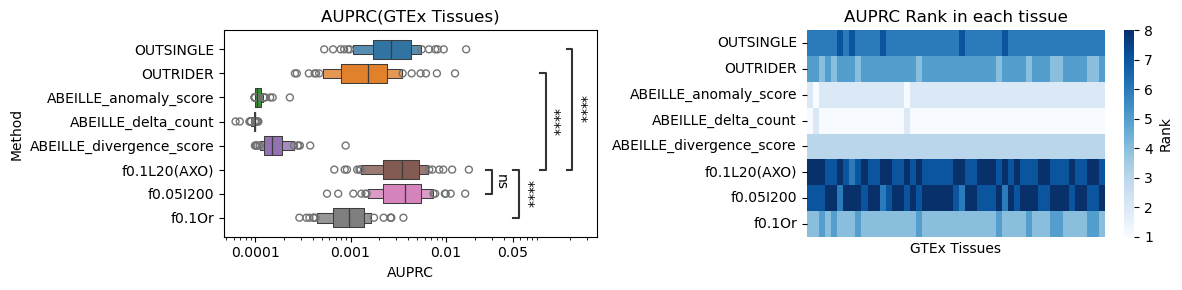

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=False, )
# (2) boxplot
# sns.boxenplot( auprc, showfliers=True, orient='h', ax=axes[1],)
if phase == '_valid':

    draw_methods = ['OUTSINGLE',
    'OUTRIDER_padjust',
    'ABEILLE_anomaly_score',
    'ABEILLE_delta_count',
    'ABEILLE_divergence_score',
    'f0.1L20',
    'f0.05I200',
    'f0.1Or']

    draw_methods_new_name = [
    'OUTSINGLE',
    'OUTRIDER',
    'ABEILLE_anomaly_score',
    'ABEILLE_delta_count',
    'ABEILLE_divergence_score',
    'f0.1L20(AXO)',
    'f0.05I200',
    'f0.1Or']
    
else:
    pass

ax_i = 0
auprc_long = auprc[draw_methods].astype(np.float32).stack().reset_index(name='AUPRC').rename(columns={'level_1':'Method', 'level_0':'Tissue'})
sns.boxenplot( auprc_long,  x = 'AUPRC', y='Method', orient='h', hue='Method', ax=axes[ax_i],)
axes[ax_i].set_xscale('log')
ticks = [ 0.0001, 0.001, 0.01, 0.05,]
axes[ax_i].set_xticks(ticks)
axes[ax_i].set_xticklabels([str(t) for t in ticks])
axes[ax_i].set_xlabel('AUPRC')
axes[ax_i].set_title('AUPRC(GTEx Tissues)')

import itertools

# pairs = list(itertools.combinations(draw_methods, 2))
# pairs = [ pair for pair in  pairs if ('f0.1L20' in pair) or ('f0.05I200' in pair) ]
pairs = [('OUTRIDER_padjust', 'f0.1L20'),  ('OUTSINGLE', 'f0.1L20'), ('f0.1L20', 'f0.05I200'),  ('f0.1L20', 'f0.1Or')]
print(pairs)
# pairs=[("f20L", "f23L"),("f21L", "f23L"),("f22L", "f23L")]
annotator = Annotator(axes[ax_i], pairs, data=auprc_long,   x = 'AUPRC', y='Method',orient='h' )
annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
annotator.apply_and_annotate()

# （3） ascending 
auprc_rank = auprc[draw_methods].rank(axis=1, method='min')
sns.heatmap(
    auprc_rank.T,  # 原始值作为注释
    annot=False,  # 显示数值
    fmt='.3f',  # 数值格式
    cmap='Blues',  # 使用蓝色渐变
    cbar_kws={'label': 'Rank'},  # 色条标签
    linecolor=None, linewidths=0.05,
    xticklabels=False,
    yticklabels=True,
    ax=axes[1],
)

axes[1].set_title('AUPRC Rank in each tissue')
axes[1].set_xlabel('GTEx Tissues')
axes[0].set_yticklabels(draw_methods_new_name)
axes[1].set_yticklabels(draw_methods_new_name)

plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/gtex{phase}_auprc_box_best_compare.pdf', dpi=200)

In [143]:
# p-value
auprc = auprc.astype(np.float32)

from scipy.stats import wilcoxon, shapiro, ttest_rel
import itertools
import pandas as pd

columns = auprc.columns.tolist()
results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

for method1, method2 in itertools.combinations(columns, 2):
    x = auprc[method1].dropna()
    y = auprc[method2].dropna()
    
    # make they are same length
    min_len = min(len(x), len(y))
    x = x.iloc[:min_len]
    y = y.iloc[:min_len]
    
    # wilcoxon test
    alternative = 'two-sided'
    stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

    new_row = pd.DataFrame({
        'Method1': [method1],
        'Method2': [method2],
        'Statistic': [stat],
        'p-value': [p_value]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)

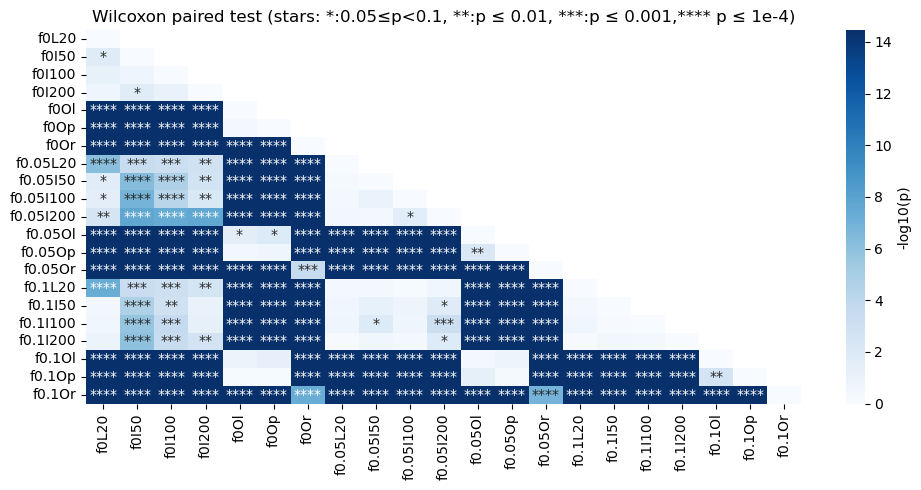

In [ ]:

axo_results = results#.query('(Method1 in @draw_methods) and (Method2 in @draw_methods)')
# ---- 1. 对称矩阵化 ----
pivot = axo_results.pivot(index='Method1', columns='Method2', values='p-value')
pivot = pivot.combine_first(pivot.T)        # 补全下三角
np.fill_diagonal(pivot.values, 1)           # 对角=1
pivot = pivot.loc[methods, methods]
# ---- 2. -log10 变换 ----
log_p = -np.log10(pivot)
log_p = log_p.replace([np.inf, -np.inf], np.nan)

# ---- 3. 三角掩码 ----
mask = np.triu(np.ones_like(log_p, dtype=bool), k=1)

def p2star(p):
    if pd.isna(p) or p > 0.05:
        return ''
    elif p <= 1e-4:
        return '****'
    elif p <= 1e-3:
        return '***'
    elif p <= 1e-2:
        return '**'
    else:
        return '*'

# 1. 星号对称矩阵（同索引）
star_mat = pivot.applymap(p2star)

# ---- 4. 画图 ----
plt.figure(figsize=(10, 5))
sns.heatmap(log_p,
            mask=mask,
            cmap='Blues',
            annot=star_mat,
            fmt='',
            cbar_kws={'label': '-log10(p)'})
plt.title('Wilcoxon paired test (stars: *:0.05≤p<0.1, **:p ≤ 0.01, ***:p ≤ 0.001,**** p ≤ 1e-4)')
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/gtex{phase}_auprc_wilcox_p_star.pdf', dpi=200)
plt.show()

## Method 

In [67]:
# p-value
auprc = auprc.astype(np.float32)

from scipy.stats import wilcoxon, shapiro, ttest_rel
import itertools
import pandas as pd

columns = auprc.columns.tolist()
results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

for method1, method2 in itertools.combinations(columns, 2):
    x = auprc[method1].dropna()
    y = auprc[method2].dropna()
    
    # make they are same length
    min_len = min(len(x), len(y))
    x = x.iloc[:min_len]
    y = y.iloc[:min_len]
    
    # wilcoxon test
    alternative = 'two-sided'
    stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

    new_row = pd.DataFrame({
        'Method1': [method1],
        'Method2': [method2],
        'Statistic': [stat],
        'p-value': [p_value]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)

In [70]:
# # Supplemental Table output
# pivot.to_excel(f'{workdir}/result/table/s1_nmd_rare_stop_gained.xlsx', sheet_name='s1_gtex_nmd',index=True)